In [1]:

import numpy as np
import os

import subprocess
from datetime import date
import xarray as xr
import pandas as pd
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

from itertools import product
from dask.distributed import wait, progress, Client, LocalCluster
from pathlib import Path
from urllib.request import urlopen
from glob import glob


import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import gc
from osgeo import gdal
from functools import reduce

from multiprocessing import Pool
from datetime import datetime 

In [2]:

gc.collect()

0

In [4]:
# View dashboard by forwarding remote port 7777 to local port (e.g. 9000), open localhost:9000 in browser
cluster = LocalCluster(
    dashboard_address = "localhost:45601",
    n_workers = 36, 
    threads_per_worker=1,
    memory_limit = "15GB",
    local_directory = "/data/tmp/snair/tmp/dask-worker-space"
)
client = Client(cluster)

In [ ]:
workplan

- first, read the daily data, convert to yearmon, take the mean and write. 
- read historical data, and take mean.
- subtract and save final output. 

In [3]:
cmip6dir = Path("/data/climate_migration/data/cmip6/")

In [4]:
def day2month(
    exp, 
    model='ssp126', 
    start=2090, 
    end=2100,
    agg_func = 'mean',
    out_save = False, 
    parallel = True
):
    
    flist = glob(f"{str(cmip6dir)}/nex_gddp_cmip6/*/*{model}*.nc")
    flist = np.sort([f for f in flist for t in np.arange(start, end) if str(t) in f])
    
    flist_360 = list(np.unique([f for f in flist if exp in f]))
    if len(flist_360)>0:

        df_360 = xr.open_mfdataset(flist_360, combine='nested', concat_dim='time')
        df_360 = df_360.rename({"tas": f"tas_{exp}"})
        yearmons = [np.datetime64(str(d).split('T')[0][:7]) for d in df_360.time.values]
        df_360 = df_360.assign_coords(yearmon = ('time',yearmons)).swap_dims({'time':'yearmon'})
        df_360 = getattr(df_360.groupby('yearmon'), agg_func)()
        

    if parallel:
        df_360 = df_360.compute()

    if out_save:
        print("completed")
        df_360.to_netcdf(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/raw/tas_{exp}_{model}_{start}_{end}.nc")
    else:
        print("completed")
        return df_360
    
def day2month_concat(
    model = 'ssp126', 
    start = 2090, 
    end = 2100,
    agg_func='mean', 
    out_save=True
):
    experiments = list(np.unique([f.split("/")[-2] for f in glob(f"{str(cmip6dir)}/nex_gddp_cmip6/*/*{model}*.nc")]))

    futures = client.map(day2month, 
                              experiments, 
                              model = model, 
                              start = int(start), 
                              end = int(end), 
                              agg_func = agg_func, 
                              out_save = False
                             )


    df_lists = [f.result() for f in futures]
    df_final = xr.merge(df_lists)
    
    npmean = getattr(df_final.to_array(dim='new'), agg_func)('new', skipna = False)
    df_final[f'all_model_{agg_func}']=npmean
    
    df_final.coords['lon'] = (df_final.coords['lon'] + 180) % 360 - 180
    df_final = df_final.sortby(df_final.lon)
    
    df_final = getattr(df_final, agg_func)("yearmon")
    
    if out_save:
        df_final.to_netcdf(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/month_aggs/tas_{model}_{start}_{end}.nc")
        
        
        
def run_exactextract(args):
    
    col = args[0]
    out_name = args[1]
    in_file = args[2]
    
    warnings.filterwarnings('ignore')
    
    if out_name is None:
        out_name = f"{model}_{col}_{fstart}_{fend}_{hstart}_{hend}"
        
    command1 = ["~/bin/exactextract", 
               f'-r "tas:NETCDF:{in_file}:{col}"',  
                '-p /data/climate_migration/shp/gadm36_1.shp -f GID_1',
                f'-s "{col}_mean=mean(tas)"',
                f'-o {str(cmip6dir)}/nex_gddp_cmip6_clean/gadm1/{model}/{out_name}_mean_unweighted.csv']
    
    command2 = ['~/bin/exactextract', 
        f'-r "tas:NETCDF:{in_file}:{col}"', 
        '-r "pop:/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020.tif"', 
        '-p /data/climate_migration/shp/gadm36_1.shp -f GID_1', 
        f'-s "{col}_pop_mean=weighted_mean(tas,pop)"', 
        f'-o /data/climate_migration/data/cmip6/nex_gddp_cmip6_clean/gadm1/{model}/{out_name}_mean_popweighted.csv']
    try:
        os.system(' '.join(command1))
        os.system(' '.join(command2))
        return 'Success'
    except:
        return 'Failed'

def read_rename(f):
    
    if 'all_model_mean' not in f:
        expname = f.split("/")[-1].split("_")[2]
    else:
        expname = 'all_model_mean'
        
    df = pd.read_csv(f)
    cols = {c:'tas_'+expname for c in df.columns if c!='GID_1'}
    df = df.rename(columns = cols)
    return df



### aggregate days to months

In [ ]:
warnings.filterwarnings('ignore')
for m in ['ssp245', 'ssp370', 'ssp585']:
#     day2month_concat(model = m)
    day2month_concat(model = m, 
                    start = 2080, 
                    end = 2100)

In [ ]:
warnings.filterwarnings('ignore')
for m in ['historical']:
    day2month_concat(model = m, 
                    start = 2005, 
                    end = 2015)
    
    day2month_concat(model = m, 
                    start = 1995, 
                    end = 2015)

#### Historical

In [5]:
filelist = pd.read_csv("gddp-cmip6-files.csv")


#Some cleaning of file urls
filelist = filelist.rename(columns = {' fileURL':"fileURL"})
filelist['tas'] = filelist['fileURL'].apply(lambda x: 'tas_day' in x)
filelist = filelist[filelist['tas'] == 1]

historical = filelist[filelist['fileURL'].apply(lambda x: 'historical' in x)].copy()

# filelist = filelist[filelist['fileURL'].apply(lambda x: 'historical' not in x)]
filelist['experiment'] = filelist['fileURL'].apply(lambda x: x.split("/")[4])
filelist['model'] = filelist['fileURL'].apply(lambda x: x.split("/")[5])
filelist['filestub'] = filelist.fileURL.apply(lambda x:x.split("/")[-1]).apply(lambda x: x.split('_')[-2])
filelist['type'] = filelist.fileURL.apply(lambda x: x.split("/")[6])
filelist['filename'] = filelist.fileURL.apply(lambda x: x.split("/")[-1])
master = filelist[['experiment', 'model', 'filestub', 'type']].drop_duplicates().sort_values(['experiment', 'model'])

In [6]:
gc.collect()

0

In [194]:
for model in ['historical']:
    for hstart, hend in [
        (2005, 2015),
        (1995, 2015),

    ]:
        gc.collect()
        print(model, hstart, 'Started', datetime.now())
        filename = f"tas_historical_{hstart}_{hend}"

        if not os.path.isfile(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/month_aggs/{filename}_final.nc"):
            hr = xr.open_dataset(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/month_aggs/{filename}.nc")
            hr = hr.drop_vars('all_model_mean')

            models = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

            for model in models:
                hrvars = list(hr.data_vars)
                experiments = master[master.model == model].experiment.unique()
                drop_vars = set(hrvars) - set(['tas_'+v for v in experiments])
                print(drop_vars)
                hr_temp = hr.drop_vars(drop_vars)

                npmean = hr_temp.to_array(dim='new').mean('new', skipna = False)
                hr[f'{model}_mean']=npmean

            npmean = hr.drop_vars([f'{m}_mean' for m in models]).to_array(dim='new').mean('new', skipna = False) 
            hr['all_model_mean']=npmean
            hr.to_netcdf(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/month_aggs/{filename}_final.nc")

        hr = xr.open_dataset(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/month_aggs/{filename}_final.nc")
        filename = f"{filename}_final.nc"

        numvars = len(hr.data_vars)

        print("Pool started", numvars)
        pool = Pool(numvars)

        results = pool.map(run_exactextract, 
                           [(dv, f'historical_tas_{dv}_{hstart}_{hend}', f"{str(cmip6dir)}/nex_gddp_cmip6_clean/month_aggs/{filename}")
                            for dv in list(hr.data_vars)])

        pool.close()
        pool.join()

        print('Completed')

        gc.collect()


historical 2005 Started 2023-03-24 20:13:24.243959
Pool started 40


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

Completed
historical 1995 Started 2023-03-24 20:15:20.903639
Pool started 40


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

Completed


#### Calculate differences

In [191]:
warnings.filterwarnings('ignore')
models = [
    'ssp126', 
    'ssp245', 
    'ssp370', 
    'ssp585'
]
for m in models :
    for fstart, fend, hstart, hend in [
        (2090, 2100, 2005, 2015),
        (2080, 2100, 1995, 2015),
        
    ]:
        df_future = xr.open_dataset(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/month_aggs/tas_{m}_{fstart}_{fend}.nc")
        df_historical = xr.open_dataset(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/month_aggs/tas_historical_{hstart}_{hend}_final.nc")
        
        df_historical = df_historical.drop_vars(['all_model_mean'] + [f'{mo}_mean' for mo in list(set(models) - set([m]))])
        
        df_historical = df_historical.rename({f'{m}_mean':'all_model_mean'})
        df_diff = df_future - df_historical
        
        assert len(df_diff.data_vars) == len(df_future.data_vars)
        
        df_diff.to_netcdf(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/diffs/tas_{m}_{fstart}_{fend}_{hstart}_{hend}_diff.nc")

In [7]:
gc.collect()

0

In [8]:
for model in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    for fstart, fend, hstart, hend in [
        (2090, 2100, 2005, 2015),
        (2080, 2100, 1995, 2015),
        
    ]:
        print(model, 'Started', datetime.now())
        filename = f"tas_{model}_{fstart}_{fend}_{hstart}_{hend}_diff.nc"
        df_diff = xr.open_dataset(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/diffs/{filename}")

        numvars = len(df_diff.data_vars)

        pool = Pool(numvars)

        results = pool.map(run_exactextract, 
                           [(dv, None, f"{str(cmip6dir)}/nex_gddp_cmip6_clean/diffs/tas_{model}_{fstart}_{fend}_{hstart}_{hend}_diff.nc") 
                            for dv in list(df_diff.data_vars)])

        pool.close()
        pool.join()

        
    print('Completed')

ssp126 Started 2023-03-24 20:27:43.575226


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

ssp126 Started 2023-03-24 20:29:53.204390


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

Completed
ssp245 Started 2023-03-24 20:32:01.902502


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

ssp245 Started 2023-03-24 20:34:12.097636


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

Completed
ssp370 Started 2023-03-24 20:36:24.550081


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

ssp370 Started 2023-03-24 20:38:27.428319


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

Completed
ssp585 Started 2023-03-24 20:40:30.180786


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

ssp585 Started 2023-03-24 20:42:41.265588


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Warning 1: No UNIDATA NC_GLO

Completed


#### create final combined files. 

In [28]:
for model in ['ssp126', 'ssp245','ssp370', 'ssp585']:
    for stub in ['2080', '2090']:
        filelist = glob(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/gadm1/*/{model}*{stub}*pop*.csv")
        df_proj = reduce(lambda x, y: pd.merge(x, y, on = 'GID_1'), 
                                  [read_rename(f) for f in filelist])

        df_proj = df_proj[['GID_1', 'tas_all_model_mean'] + 
                                              list(np.sort([c for c in df_proj.columns 
                                                            if c not in ['GID_1', 'tas_all_model_mean']]))]

        df_proj.to_csv(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/gadm1/final/{model}_projected_change_{stub}_2100_v1.csv", index = False)

In [43]:
def read_rename_historical(f):
    
    if 'all_model_mean' not in f:
        expname = f.replace("tas_tas", "tas").split("/")[-1].split("_")[2]
    else:
        expname = 'all_model_mean'
        
    df = pd.read_csv(f)
    cols = {c:'tas_'+expname for c in df.columns if c!='GID_1'}
    df = df.rename(columns = cols)
    return df


warnings.filterwarnings('ignore')
for model in ['historical']:
    for stub in ['1995', '2005']:
        filelist = glob(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/gadm1/historical/{model}*{stub}*pop*.csv")
        df_proj = reduce(lambda x, y: pd.merge(x, y, on = 'GID_1'), [read_rename_historical(f) for f in filelist])

        df_proj = df_proj[['GID_1', 'tas_all_model_mean', 'tas_ssp126', 'tas_ssp245', 'tas_ssp370', 
                          'tas_ssp585'] + 
                                              list(np.sort([c for c in df_proj.columns 
                                                            if c not in ['GID_1', 'tas_all_model_mean']]))]

        df_proj.to_csv(f"{str(cmip6dir)}/nex_gddp_cmip6_clean/gadm1/final/{model}_{stub}_2015_v1.csv", index = False)

In [42]:
df_proj

,GID_1,tas_all_model_mean,tas_ssp126,tas_ssp245,tas_ssp370,tas_ssp585,tas_ACCESS-CM2,tas_ACCESS-ESM1-5,tas_BCC-CSM2-MR,tas_CESM2,...,tas_MRI-ESM2-0,tas_NESM3,tas_NorESM2-LM,tas_NorESM2-MM,tas_TaiESM1,tas_UKESM1-0-LL,tas_ssp126,tas_ssp245,tas_ssp370,tas_ssp585
0,AFG.1_1,282.350769,282.359467,282.353363,282.369934,282.350769,282.478851,282.247925,281.690521,282.512268,...,281.779053,281.852051,282.017975,282.204102,286.382568,282.504150,282.359467,282.353363,282.369934,282.350769
1,AFG.2_1,287.384735,287.402039,287.383179,287.428772,287.384735,287.186676,287.469666,286.690704,287.474335,...,286.787628,286.962921,286.888885,287.171295,291.817932,287.539886,287.402039,287.383179,287.428772,287.384735
2,AFG.3_1,285.847504,285.866669,285.847351,285.883484,285.847504,285.887268,285.811493,285.277222,285.992096,...,285.260040,285.419434,285.401276,285.656372,289.955475,286.017242,285.866669,285.847351,285.883484,285.847504
3,AFG.4_1,290.275940,290.291382,290.273346,290.316345,290.275940,290.062561,290.300476,289.587463,290.385529,...,289.657837,289.873413,289.809875,290.048645,294.648071,290.505737,290.291382,290.273346,290.316345,290.275940
4,AFG.5_1,278.538177,278.553619,278.537811,278.563019,278.538177,278.598450,278.449432,277.875763,278.755219,...,277.961609,278.127808,277.995331,278.629364,282.547638,278.635651,278.553619,278.537811,278.563019,278.538177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,ZWE.6_1,295.865387,295.906586,295.870605,295.941162,295.865387,295.742218,295.868195,295.660706,294.855469,...,295.629791,295.509705,295.607422,295.834259,300.136658,295.433044,295.906586,295.870605,295.941162,295.865387
3606,ZWE.7_1,295.572998,295.607330,295.579865,295.646515,295.572998,295.327179,295.527679,295.374725,294.581329,...,295.388641,295.104279,295.346069,295.366211,300.256409,294.998993,295.607330,295.579865,295.646515,295.572998
3607,ZWE.8_1,296.672607,296.715240,296.678009,296.741058,296.672607,296.505737,296.590240,296.423584,295.577362,...,296.417145,296.265503,296.395508,296.529907,301.338409,296.180328,296.715240,296.678009,296.741058,296.672607
3608,ZWE.9_1,295.771729,295.812805,295.776855,295.845520,295.771729,295.520233,295.637970,295.474548,294.658691,...,295.521027,295.244598,295.546356,295.525604,300.603638,295.178711,295.812805,295.776855,295.845520,295.771729


In [16]:
filelist = glob(f"{cmip6dir}/nex_gddp_cmip6_clean/gadm1/global/*.csv")

In [35]:
target_res = 0.25
bbox=[-180,-90,180,90]
output = "/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020_grid_average.tif"
inputras = "/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020.tif"


kwargs = {'target_res':0.25, 
         'bbox':[-180,-90,180,90]}
op = gdal.Warp(output, inputras, outputBounds=bbox, xRes=target_res, yRes=target_res, resampleAlg = gdal.GRA_Average, 
               outputType=gdal.GDT_Float32)
op = None
output = None
inputras = None

In [42]:
import netCDF4

In [81]:
df_diff.mean()

<xarray.Dataset>
Dimensions:               ()
Data variables: (12/36)
    tas_ACCESS-CM2        float32 6.846
    tas_ACCESS-ESM1-5     float32 5.478
    tas_BCC-CSM2-MR       float32 5.047
    tas_CESM2             float32 6.05
    tas_CESM2-WACCM       float32 5.964
    tas_CMCC-CM2-SR5      float32 6.074
    ...                    ...
    tas_NESM3             float32 6.481
    tas_NorESM2-LM        float32 4.902
    tas_NorESM2-MM        float32 5.01
    tas_TaiESM1           float32 0.3955
    tas_UKESM1-0-LL       float32 8.902
    all_model_mean        float32 5.658

In [72]:
population_file = "/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020_grid_average.tif"
with rasterio.open(population_file) as src1:
    population_data = src1.read(1)*900

In [90]:
temp = pd.read_csv("/data/climate_migration/data/cmip6/nex_gddp_cmip6_clean/gadm1/final/ssp585_projected_change_2080_2100.csv")

In [94]:
temp.mean()

/tmp/ipykernel_2856558/83982984.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp.mean()


tas_all_model_mean      4.260603
tas_ACCESS-CM2          5.410906
tas_ACCESS-ESM1-5       4.282068
tas_BCC-CSM2-MR         3.618679
tas_CESM2               4.720839
tas_CESM2-WACCM         4.595783
tas_CMCC-CM2-SR5        4.421343
tas_CMCC-ESM2           4.548449
tas_CNRM-CM6-1          5.132448
tas_CNRM-ESM2-1         4.699062
tas_CanESM5             5.985640
tas_EC-Earth3           4.863307
tas_EC-Earth3-Veg-LR    4.756208
tas_FGOALS-g3           2.961620
tas_GFDL-CM4_x          4.569551
tas_GFDL-CM4_y          4.536166
tas_GFDL-ESM4           3.443393
tas_GISS-E2-1-G         3.872159
tas_HadGEM3-GC31-LL     5.818084
tas_HadGEM3-GC31-MM     5.807859
tas_IITM-ESM            2.921414
tas_INM-CM4-8           2.953097
tas_INM-CM5-0           2.960396
tas_IPSL-CM6A-LR        5.363658
tas_KACE-1-0-G          5.189415
tas_KIOST-ESM           3.329148
tas_MIROC-ES2L          3.873385
tas_MIROC6              3.904845
tas_MPI-ESM1-2-HR       3.474565
tas_MPI-ESM1-2-LR       3.489311
tas_MRI-ES

In [89]:
temp

,GID_1,tas_all_model_mean,tas_ACCESS-CM2,tas_ACCESS-ESM1-5,tas_BCC-CSM2-MR,tas_CESM2,tas_CMCC-CM2-SR5,tas_CMCC-ESM2,tas_CNRM-CM6-1,tas_CNRM-ESM2-1,...,tas_MIROC-ES2L,tas_MIROC6,tas_MPI-ESM1-2-HR,tas_MPI-ESM1-2-LR,tas_MRI-ESM2-0,tas_NESM3,tas_NorESM2-LM,tas_NorESM2-MM,tas_TaiESM1,tas_UKESM1-0-LL
0,AFG.1_1,1.363642,2.030110,1.707765,1.249597,0.804327,-1.733487,2.538443,1.775348,1.905309,...,1.612764,1.908098,0.861005,1.131583,1.520607,1.761548,1.354363,0.822463,-3.011506,2.492903
1,AFG.2_1,1.440937,2.407155,1.636132,1.241540,0.737891,-1.703072,2.921375,1.924455,2.102096,...,1.384909,1.719669,0.952995,1.080327,1.610018,1.707502,1.331187,1.100261,-1.586284,2.827682
2,AFG.3_1,1.561364,2.270649,1.646136,1.370542,0.631979,-1.480682,2.950845,2.160397,2.396161,...,1.616909,1.750702,0.974709,1.176552,1.622713,1.851415,1.245024,0.856921,-0.912342,2.897395
3,AFG.4_1,1.455698,2.477781,1.562386,1.349402,0.583712,-1.723607,2.892113,2.025462,2.088721,...,1.449158,1.687582,1.002597,1.198510,1.551576,1.777143,1.217238,0.998214,-1.811201,3.082042
4,AFG.5_1,1.633141,2.334954,1.755521,1.371178,1.090352,-1.417742,2.917694,2.247163,2.472709,...,1.561456,1.743751,0.966607,1.103670,1.683697,1.871480,1.246822,0.902712,-0.853017,3.333098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,ZWE.6_1,0.973188,2.430080,1.338738,0.646207,1.515159,-3.529634,1.484560,2.008168,2.012583,...,0.585001,1.021954,0.788354,0.473194,1.463805,1.065054,0.870957,0.379346,-3.223806,1.885578
3606,ZWE.7_1,1.005629,2.437141,1.299550,0.512145,1.593242,-4.088095,1.514291,2.100672,2.037243,...,0.822226,1.114987,0.858026,0.452589,1.303209,0.984320,0.893967,0.586703,-4.012513,2.106435
3607,ZWE.8_1,0.995159,2.468074,1.321726,0.690281,1.457678,-3.966141,1.525536,2.194118,2.083529,...,0.844824,1.139827,0.882778,0.433215,1.506139,1.040037,0.676977,0.395818,-3.436872,2.187639
3608,ZWE.9_1,1.031358,2.450076,1.228866,0.653011,1.749503,-4.489376,1.526570,2.301660,2.036995,...,1.042247,1.258660,0.897225,0.487950,1.392258,1.126944,0.878618,0.614933,-4.158465,2.283556


In [92]:
total_weighted_temperature

13106238309004.969

In [87]:
# Load the population raster
population_file = "/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020_ERA5grid.tif"
with rasterio.open(population_file) as src1:
    population_data = src1.read(1)*900
population_data = population_data[:600, ]

# Load the temperature netCDF file
temperature_file = f"{str(cmip6dir)}/nex_gddp_cmip6_clean/diffs/tas_ssp585_2080_2100_1995_2015_diff.nc"
with netCDF4.Dataset(temperature_file) as src2:
    temperature_data = src2.variables['all_model_mean'][:] # Replace 'temperature' with the correct variable name
temperature_data = temperature_data[:, :-1]

# Apply the binary mask to the population data
binary_mask = np.where(population_data > 0, 1, 0)
population_masked = population_data * binary_mask

# Calculate the weighted average temperature
weighted_temperature = temperature_data * population_masked
total_weighted_temperature = np.sum(weighted_temperature)
total_population = np.sum(population_masked)
average_temperature = total_weighted_temperature / total_population

print(f"Global average temperature (weighted by population): {average_temperature}")

Global average temperature (weighted by population): 1.8966914483598605


In [86]:
population_data.shape, temperature_data.shape

((600, 1438), (600, 1440))

In [189]:
temperature_file = None
gc.collect()

0

In [287]:
population_file = "/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020.tif"
with rasterio.open(population_file) as src0:
    population_data0 = src0.read(1)

In [320]:
# from rasterio.enums import Resampling

# xres, yres = 0.25, 0.25

# with rasterio.open("/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020.tif") as dataset:
#     scale_factor_x = dataset.res[0]/xres
#     scale_factor_y = dataset.res[1]/yres

#     profile = dataset.profile.copy()
#     # resample data to target shape
#     data = dataset.read(
#         out_shape=(
#             dataset.count,
#             int(dataset.height * scale_factor_y),
#             int(dataset.width * scale_factor_x)
#         ),
#         resampling=Resampling.sum
#     )

#     # scale image transform
#     transform = dataset.transform * dataset.transform.scale(
#         (1 / scale_factor_x),
#         (1 / scale_factor_y)
#     )
#     profile.update({"height": data.shape[-2],
#                     "width": data.shape[-1],
#                    "transform": transform})

# with rasterio.open("/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020_new.tif", "w", **profile) as dataset:
#     dataset.write(data)

ResamplingAlgorithmError: <Resampling.sum: 13> can be used for warp operations but not for reads and writes

In [305]:
population_file = "/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020_newgrid.tif"
with rasterio.open(population_file) as src1:
    population_data1 = src1.read(1)
    
    
len(population_data1[(population_data1 != -2.1474836e+09) & (population_data1 != 0)]*900)

175262

In [290]:
population_data1.shape

(720, 1440)

In [304]:
population_file = "/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020_ERA5grid.tif"
with rasterio.open(population_file) as src2:
    population_data2 = src2.read(1)
    
    
len(population_data2[(population_data2 != -2.1474836e+09)  & (population_data2 != 0)])

175031

In [264]:
population_data[population_data!=0]

array([ 6.,  6.,  1., ..., 23., 17., 17.], dtype=float32)

In [267]:
population_data[(population_data!=-2.1474836e+09 ) & (population_data != 0)]

array([ 3.,  3.,  2., ...,  4.,  2., 11.], dtype=float32)

In [251]:
np.sum(population_data[population_data != -2.1474836e+09])

7677835000.0

In [165]:
# Define the bounding box coordinates (min_x, min_y, max_x, max_y)
min_x, min_y, max_x, max_y = -179.875, 10, -175, 15  # Replace these values with your actual bounding box coordinates
from rasterio.windows import from_bounds
# Load the population raster and subset to the bounding box
population_file = "/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020_ERA5grid.tif"
with rasterio.open(population_file) as src3:
#     window = from_bounds(min_x, min_y, max_x, max_y, src3.transform)
#     population_data = src3.read(1, window=window)
#     window_transform = src3.window_transform(window)
    band1 = src3.read(1)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(src3.transform, rows, cols)
    lons= np.array(xs)
    lats = np.array(ys)
    print('lons shape', lons.shape)

lons shape (721, 1439)


In [168]:
src3.bounds

BoundingBox(left=-179.875, bottom=-90.125, right=179.875, top=90.125)

In [167]:
lats

array([[ 90.  ,  90.  ,  90.  , ...,  90.  ,  90.  ,  90.  ],
       [ 89.75,  89.75,  89.75, ...,  89.75,  89.75,  89.75],
       [ 89.5 ,  89.5 ,  89.5 , ...,  89.5 ,  89.5 ,  89.5 ],
       ...,
       [-89.5 , -89.5 , -89.5 , ..., -89.5 , -89.5 , -89.5 ],
       [-89.75, -89.75, -89.75, ..., -89.75, -89.75, -89.75],
       [-90.  , -90.  , -90.  , ..., -90.  , -90.  , -90.  ]])

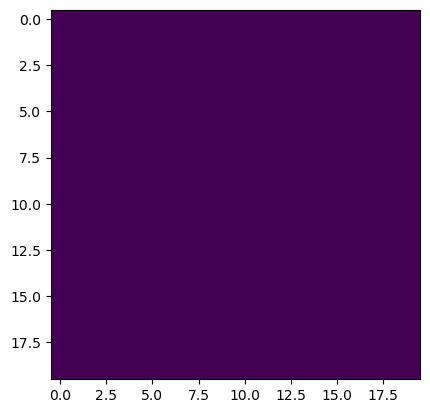

In [162]:
plt.imshow(population_data)

In [152]:
src1.xy(600, 1)

(-179.5, -60.0)

In [157]:
temp1.sel(lon=slice(-180, 179.8))

<xarray.Dataset>
Dimensions:               (lat: 600, lon: 1439)
Coordinates:
  * lat                   (lat) float64 -59.88 -59.62 -59.38 ... 89.62 89.88
  * lon                   (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6
Data variables: (12/36)
    tas_ACCESS-CM2        (lat, lon) float32 ...
    tas_ACCESS-ESM1-5     (lat, lon) float32 ...
    tas_BCC-CSM2-MR       (lat, lon) float32 ...
    tas_CESM2             (lat, lon) float32 ...
    tas_CESM2-WACCM       (lat, lon) float32 ...
    tas_CMCC-CM2-SR5      (lat, lon) float32 ...
    ...                    ...
    tas_NESM3             (lat, lon) float32 ...
    tas_NorESM2-LM        (lat, lon) float32 ...
    tas_NorESM2-MM        (lat, lon) float32 ...
    tas_TaiESM1           (lat, lon) float32 ...
    tas_UKESM1-0-LL       (lat, lon) float32 ...
    all_model_mean        (lat, lon) float32 ...

In [144]:
# Load the population raster
population_file = "/data/climate_migration/shp/global_sociodem_grids/landscan-global-2020_ERA5grid.tif"
with rasterio.open(population_file) as src1:
    population_data = src1.read(1)

# Load the temperature netCDF file
temperature_file = f"{str(cmip6dir)}/nex_gddp_cmip6_clean/diffs/{filename}"
with netCDF4.Dataset(temperature_file) as src2:
    temperature_data = src2.variables['all_model_mean'][:]  # Replace 'temperature' with the correct variable name

# Apply the binary mask to the population data
binary_mask = np.where(population_data > 0, 1, 0)
population_masked = population_data * binary_mask

# Calculate the weighted average temperature
weighted_temperature = temperature_data * population_masked
total_weighted_temperature = np.sum(weighted_temperature)
total_population = np.sum(population_masked)
average_temperature = total_weighted_temperature / total_population

print(f"Global average temperature (weighted by population): {average_temperature}")

ValueError: operands could not be broadcast together with shapes (600,1440) (721,1439) 